Import Libraries

In [4]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g., pd.read_csv)
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Load Dataset

In [5]:
dataset_path = "C:\\Users\\Maitreyi\\OneDrive\\Desktop\\BLOOD GROUP DETECTION\\dataset\\dataset_blood_group"
BATCH_SIZE = 32

# Step 1: Load dataset
dataset = image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(64, 64),  # Resize images to a standard size
    batch_size=BATCH_SIZE,
    shuffle=True
)


Found 6000 files belonging to 8 classes.


Check Class Distribution

In [6]:
class_names = dataset.class_names
class_counts = Counter()

for _, labels in dataset.unbatch():
    class_counts[int(labels.numpy())] += 1

print("Class Distribution:")
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count}")


Class Distribution:
O+: 852
A-: 1009
O-: 712
A+: 565
AB-: 761
AB+: 708
B+: 652
B-: 741


Plot Class Distribution

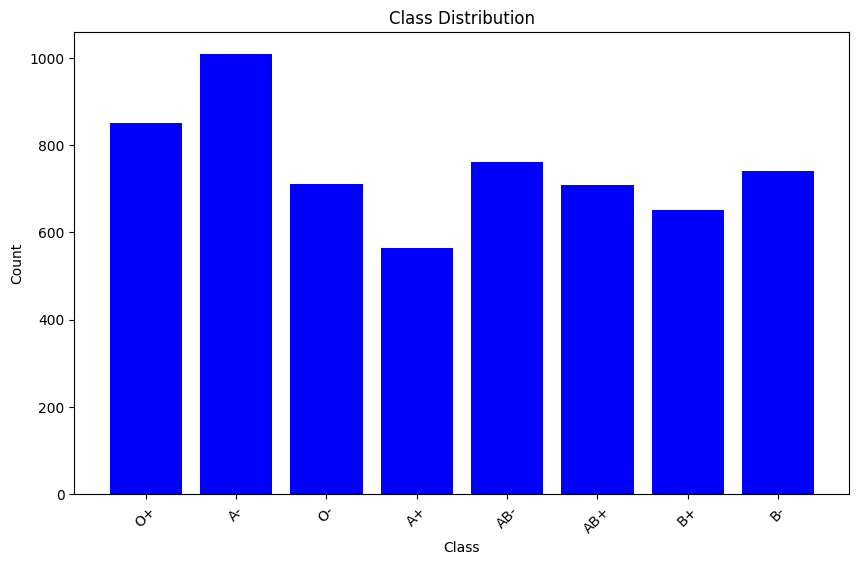

In [7]:
def plot_class_distribution(class_names, class_counts):
    """
    Plots the distribution of classes in the dataset.
    """
    classes = [class_names[i] for i in class_counts.keys()]
    counts = [class_counts[i] for i in class_counts.keys()]

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='blue')
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Class Distribution")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(class_names, class_counts)


 Oversampling to Balance Classes

In [9]:
max_count = max(class_counts.values())

def oversample_class(class_id, count, max_count):
    # Ensure the dataset is unbatched for filtering
    unbatched_dataset = dataset.unbatch()
    
    # Filter the dataset for the specific class
    class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))
    
    # Calculate the number of repetitions needed
    repeat_factor = max_count // count + (max_count % count > 0)
    
    # Repeat the dataset to match the desired count
    return class_dataset.repeat(repeat_factor).take(max_count)

balanced_datasets = [oversample_class(class_id, count, max_count) for class_id, count in class_counts.items()]
balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_datasets)


Check Balanced Class Distribution

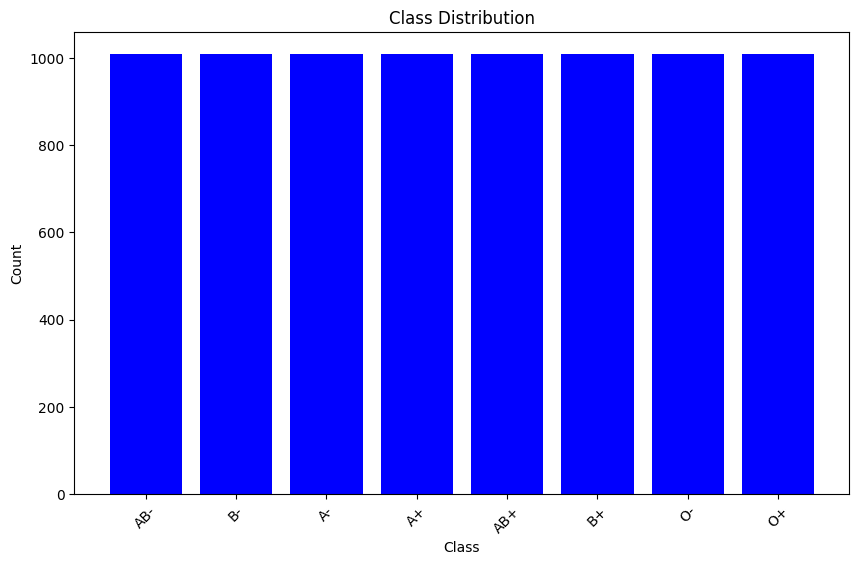

In [10]:
balanced_class_counts = Counter([int(lbl.numpy()) for _, lbl in balanced_dataset])
plot_class_distribution(class_names, balanced_class_counts)


 Split Dataset into Training, Validation, and Testing

In [12]:
dataset_size = sum(class_counts.values())
train_ratio, val_ratio = 0.7, 0.15  # 70% train, 15% validation, 15% test

train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)

train_dataset = balanced_dataset.take(train_size)
val_test_dataset = balanced_dataset.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)


Define CNN Model

In [13]:
def create_high_accuracy_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

high_acc_model = create_high_accuracy_model()


c:\Users\Maitreyi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Set Up Callbacks

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


Train the Model

In [15]:
history_high_acc = high_acc_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[reduce_lr, early_stop]
)


Epoch 1/50
    131/Unknown 21s 147ms/step - accuracy: 0.1292 - loss: 41.0913

c:\Users\Maitreyi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


131/131 ━━━━━━━━━━━━━━━━━━━━ 30s 218ms/step - accuracy: 0.1292 - loss: 40.8656 - val_accuracy: 0.1272 - val_loss: 2.0070 - learning_rate: 0.0010
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 243ms/step - accuracy: 0.1491 - loss: 2.0767 - val_accuracy: 0.2823 - val_loss: 1.8518 - learning_rate: 0.0010
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 221ms/step - accuracy: 0.3805 - loss: 1.6257 - val_accuracy: 0.5248 - val_loss: 1.2881 - learning_rate: 0.0010
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 316ms/step - accuracy: 0.5733 - loss: 1.2200 - val_accuracy: 0.6659 - val_loss: 1.0835 - learning_rate: 0.0010
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 39s 296ms/step - accuracy: 0.6068 - loss: 1.0985 - val_accuracy: 0.7823 - val_loss: 1.0108 - learning_rate: 0.0010
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 234ms/step - accuracy: 0.6614 - loss: 0.9293 - val_accuracy: 0.6379 - val_loss: 1.1931 - learning_rate: 0.0010
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 260ms/step - accuracy: 0.6783 - loss

Evaluate the Model

In [16]:
high_acc_eval = high_acc_model.evaluate(val_dataset)
print(f"High Accuracy Model - Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.8803 - loss: 0.4802
High Accuracy Model - Loss: 0.4419069290161133, Accuracy: 0.868534505367279


Plot Accuracy Graph

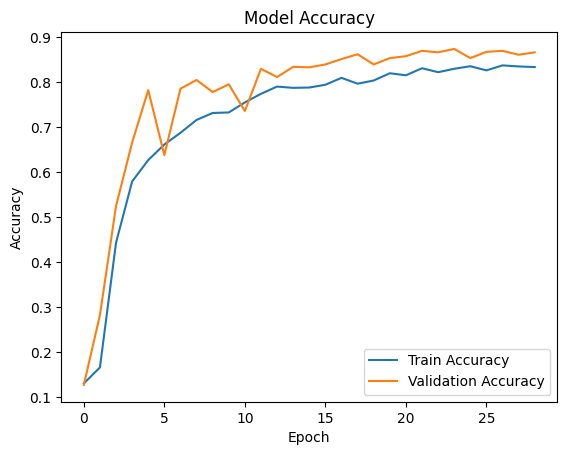

In [17]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(history_high_acc)


Generate Predictions & Evaluate Performance

In [18]:
y_true, y_pred = [], []

for images, labels in test_dataset:
    predictions = high_acc_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━

Plot Confusion Matrix

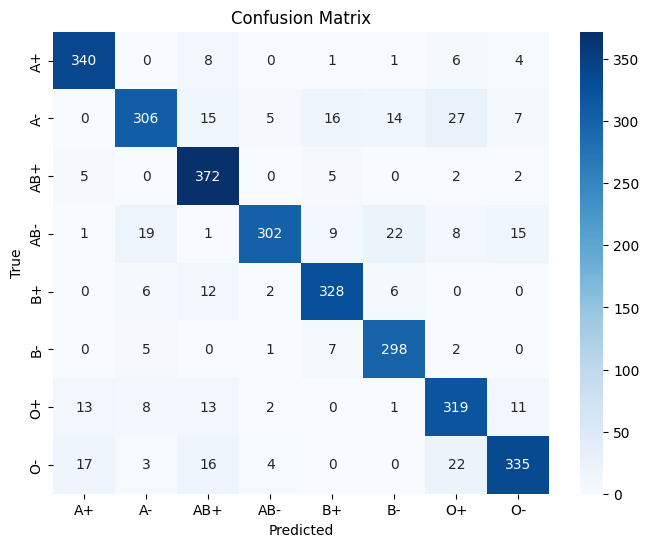

In [19]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Save the Model

In [20]:
high_acc_model.save('model.h5')
print("Model saved as HDF5 format.")


Model saved as HDF5 format.
